# Capstone Project
## Recommend Toronto neighborhoods based on gastronomy
### Bruno Baldin Florencio
---

An association of Chefs from many different countries are coming to explore Toronto for 6 months.

To enhance the experience of each member the association wants to make recommendation of neighborhoods that fit the culinary tastes of each chef
___


## Summary


### 1. Data acquisition and Cleaning
### 2. Using Foursquare API to retrieve the top 100 venues that are in each Toronto neighborhoods 
### 3. Creating a dataframe that contains the top gastronomical 20 venues in each neighbourhood
### 4. Using K-Means to Cluster the Neighborhoods
### 5. Vizualizing and defining the Clusters
### 6. Using a fictitious dataframe to simulate the choices of each Chef member of the association
### 7. Using Content-Based Recommender Systems to get the list of recommended neighborhoods for each Chef


____



## 1. Data acquisition and Cleaning

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

#Scrap data from wikipedia and store in a pandas dataframe

req = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(req.content,'lxml')
table = soup.find_all('table')[0]
df = pd.read_html(str(table))

df_to=pd.DataFrame(df[0])
df_to.head()

,Postal code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


In [2]:
#data cleaning

import numpy as np

df_to.replace("Not assigned", np.nan, inplace = True)
df_to.dropna(subset=["Borough"], axis=0, inplace=True)
df_to["Neighborhood"] = df_to["Neighborhood"].str.replace(" / ", " , ")
df_to["Neighborhood"] = df_to["Neighborhood"].str.strip()
df_to.reset_index(drop=True, inplace=True)
df_to.head()

,Postal code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park , Harbourfront"
3,M6A,North York,"Lawrence Manor , Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government"


In [3]:
#Download the file with Latitude and Longitude of each Neighborhood
link="http://cocl.us/Geospatial_data"

#create a pandas dataframe with the file
df_ll = pd.read_csv(link)
df_ll.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [4]:
df_ll.rename(columns={"Postal Code": "Postal code"}, inplace=True)
df_ll.shape

(103, 3)

In [5]:
#since the shape are the same, let's merge the two data frames together based on their Postal Code

df_to = pd.merge(df_to, df_ll, on='Postal code', how="right")
df_to.drop_duplicates(subset=["Neighborhood"], keep='first',inplace=True)
listdrop = ['Upper Rouge', 'Rosedale', 'Roselawn', 'York Mills West', 'Humberlea , Emery',
        "Old Mill South , King's Mill Park , Sunnylea , Humber Bay , Mimico NE , The Queensway East , Royal York South East , Kingsway Park South East",
 'York Mills , Silver Hills', 'Northwest', 'Woodbine Heights']
print(df_to.shape)
df_to.head()

(98, 5)


,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494


## 2. Using Foursquare API I'll retrieve the top 100 venues that are in each Toronto neighborhoods in a radius of 750 meters, and create a new data frame with the results.

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 

!pip install geopy 
from geopy.geocoders import Nominatim 
import requests 
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

!pip install folium
import folium 

print('Libraries imported.')

Libraries imported.


In [7]:
#Define Foursquare Credentials and Version

CLIENT_ID = 'WLCO3HZBQS1YAXOVMAAM1X45BXVLVB5OXQRRPSPUTDLJVHPW'
CLIENT_SECRET = 'TEWTX5TCJEDKAUOKUVEWMUX0SMSBXKER4ITL0Q1DUUSUERSB'
VERSION = '20180605' 


In [8]:
#Define a function to our goal

def getNearbyVenues(names, latitudes, longitudes, radius=750, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
                    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)



In [9]:
#using the function created above with df_to parameters 

to_venues = getNearbyVenues(names=df_to['Neighborhood'],
                                   latitudes=df_to['Latitude'],
                                   longitudes=df_to['Longitude']
                                  )



In [10]:
#Checking the size of the new dataframe and if each neighborhood had its correspondence

print(to_venues.shape)

droplist = list(set(df_to["Neighborhood"]) - set(to_venues["Neighborhood"]))
print(droplist)

(3675, 7)
['Upper Rouge']


In [11]:
#As we have some neighborhoods with no correspondence let's drop this list of neighborhoods from df_to

for i in listdrop:
    df_to = df_to[df_to['Neighborhood'] != i]
    
df_to.reset_index(drop=True, inplace=True)

#check the new size
print(df_to.shape)

(89, 5)


In [12]:
#Look at the list of Venues category

print(to_venues["Venue Category"].unique())

['Park' 'Food & Drink Shop' 'Road' 'Furniture / Home Store' 'Bus Stop'
 'Hockey Arena' 'Coffee Shop' 'Portuguese Restaurant' 'Intersection'
 'Pizza Place' 'Playground' 'Café' 'Moving Target' 'Sporting Goods Shop'
 'Bakery' 'Distribution Center' 'Spa' 'Restaurant' 'Historic Site'
 'Breakfast Spot' 'Farmers Market' 'Chocolate Shop' 'Dessert Shop'
 'Mediterranean Restaurant' 'Performing Arts Venue' 'Pub'
 'French Restaurant' 'Italian Restaurant' 'Tech Startup'
 'Mexican Restaurant' 'Liquor Store' 'Event Space' 'Theater'
 'Animal Shelter' 'Thai Restaurant' 'Shoe Store' 'Ice Cream Shop'
 'Yoga Studio' 'Asian Restaurant' 'Pool' 'Cosmetics Shop' 'Sandwich Place'
 'Gastropub' 'Food Truck' 'Gym Pool' 'Pet Store' 'Bar' 'Electronics Store'
 'Bank' 'Beer Store' 'Skating Rink' 'Pharmacy' 'Fast Food Restaurant'
 'Discount Store' 'Hotel' 'Grocery Store' 'Health Food Store' 'Wine Shop'
 'Antique Shop' 'Health & Beauty Service' 'Tram Station'
 'Thrift / Vintage Store' 'Athletics & Sports' 'Mobile Phone

### 3. Creating a dataframe that contains the top gastronomical 20 venues in each neighbourhood

In [13]:
#string list
gastro_venues = ["Coffee Shop", "Restaurant", "Café", "Bakery", "Breakfast", "Pastry", "Cafe", "Snack",
                 "Food", "Bar", "Churrascaria", "BBQ", "Noodle", "Joint", "Deli", "Cupcake", "Soup", "Pub"
                "Bistro", "Creperie", "Burrito", "Dessert", "Taco", "Diner"]

#filter to_venues

to_venues = to_venues[to_venues["Venue Category"].str.contains('|'.join(gastro_venues))]

print(to_venues.shape)
to_venues.head(10)


(1836, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
6,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
7,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
11,Victoria Village,43.725882,-79.315572,JJ Bean,43.720229,-79.313561,Café
15,"Regent Park , Harbourfront",43.654260,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
16,"Regent Park , Harbourfront",43.654260,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
19,"Regent Park , Harbourfront",43.654260,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
21,"Regent Park , Harbourfront",43.654260,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
24,"Regent Park , Harbourfront",43.654260,-79.360636,Rooster Coffee,43.651900,-79.365609,Coffee Shop
25,"Regent Park , Harbourfront",43.654260,-79.360636,Arvo,43.649963,-79.361442,Coffee Shop


In [14]:
#take a second look at all the venues category
print(to_venues["Venue Category"].unique())

['Food & Drink Shop' 'Coffee Shop' 'Portuguese Restaurant' 'Café' 'Bakery'
 'Restaurant' 'Breakfast Spot' 'Dessert Shop' 'Mediterranean Restaurant'
 'French Restaurant' 'Italian Restaurant' 'Mexican Restaurant'
 'Thai Restaurant' 'Asian Restaurant' 'Food Truck' 'Bar'
 'Fast Food Restaurant' 'Health Food Store' 'Vietnamese Restaurant'
 'Fried Chicken Joint' 'Sushi Restaurant' 'Greek Restaurant'
 'Seafood Restaurant' 'Korean Restaurant' 'Beer Bar' 'Creperie'
 'Burrito Place' 'Ramen Restaurant' 'Diner' 'Middle Eastern Restaurant'
 'Wings Joint' 'Burger Joint' 'Vegetarian / Vegan Restaurant'
 'Modern European Restaurant' 'Indian Restaurant' 'Japanese Restaurant'
 'Falafel Restaurant' 'Deli / Bodega' 'Wine Bar' 'Juice Bar'
 'African Restaurant' 'Caribbean Restaurant' 'American Restaurant'
 'Chinese Restaurant' 'New American Restaurant' 'German Restaurant'
 'Latin American Restaurant' 'BBQ Joint' 'Cocktail Bar' 'Sports Bar'
 'Comfort Food Restaurant' 'Molecular Gastronomy Restaurant'
 'Easte

In [15]:
#Renaming some secondary categories into a mains categories to make the prediction more accurate

to_venues["Venue Category"]=to_venues["Venue Category"].replace(["Café", "Gaming Cafe"], "Coffee Shop")
to_venues["Venue Category"]=to_venues["Venue Category"].replace(["Beer Bar","Bar","Wine Bar","Cocktail Bar", "Sports Bar", "Karaoke Bar",
                                      "Hotel Bar","Beach Bar","Gay Bar", "Dive Bar","Hookah Bar","Sake Bar"], "Bar and Pub")
to_venues["Venue Category"]=to_venues["Venue Category"].replace(["Brazilian Restaurant", "Churrascaria","Empanada Restaurant"], "South American Restaurant")
to_venues["Venue Category"]=to_venues["Venue Category"].replace("Creperie", "French Restaurant")
to_venues["Venue Category"]=to_venues["Venue Category"].replace(["Dessert Shop","Pastry Shop","Cupcake Shop"], "Dessert Restaurant")
to_venues["Venue Category"]=to_venues["Venue Category"].replace(["Breakfast Spot","Bed & Breakfast"], "Breakfast Restaurant")
to_venues["Venue Category"]=to_venues["Venue Category"].replace(["Sushi Restaurant","Udon Restaurant", "Noodle House","Dim Sum Restaurant","Dumpling Restaurant",
                                                                 "Shanghai Restaurant","Cantonese Restaurant","Thai Restaurant","Korean Restaurant", "Chinese Restaurant",
                                                                 "Indian Chinese Restaurant", "Tibetan Restaurant","Indonesian Restaurant", "Filipino Restaurant", "Japanese Restaurant",
                                                                 "Malay Restaurant","Taiwanese Restaurant","Ramen Restaurant","Hakka Restaurant","Vietnamese Restaurant",
                                                                 "Indian Restaurant","Falafel Restaurant","Afghan Restaurant"], "Asian Restaurant")
to_venues["Venue Category"]=to_venues["Venue Category"].replace(["New American Restaurant", "Cajun / Creole Restaurant","Burrito Place", "Taco Place","Mexican Restaurant","Hawaiian Restaurant"], "North American Restaurant")
to_venues["Venue Category"]=to_venues["Venue Category"].replace(["Cuban Restaurant", "Caribbean Restaurant" ], "Central American Restaurant")
to_venues["Venue Category"]=to_venues["Venue Category"].replace(["Portuguese Restaurant", "Mediterranean Restaurant", "French Restaurant", "Italian Restaurant","Greek Restaurant",
                                                                 "Modern European Restaurant", "German Restaurant", "Eastern European Restaurant", "Tapas Restaurant","Polish Restaurant","Belgian Restaurant"], "European Restaurant")
to_venues["Venue Category"]=to_venues["Venue Category"].replace(["Middle Eastern Restaurant","Turkish Restaurant","Ethiopian Restaurant","Syrian Restaurant",], "Middle East Restaurant")


print(to_venues["Venue Category"].unique())

['Food & Drink Shop' 'Coffee Shop' 'European Restaurant' 'Bakery'
 'Restaurant' 'Breakfast Restaurant' 'Dessert Restaurant'
 'North American Restaurant' 'Asian Restaurant' 'Food Truck' 'Bar and Pub'
 'Fast Food Restaurant' 'Health Food Store' 'Fried Chicken Joint'
 'Seafood Restaurant' 'Diner' 'Middle East Restaurant' 'Wings Joint'
 'Burger Joint' 'Vegetarian / Vegan Restaurant' 'Deli / Bodega'
 'Juice Bar' 'African Restaurant' 'Central American Restaurant'
 'American Restaurant' 'Latin American Restaurant' 'BBQ Joint'
 'Comfort Food Restaurant' 'Molecular Gastronomy Restaurant' 'Food Court'
 'South American Restaurant' 'Salon / Barbershop' 'Soup Place' 'Food'
 'Cafeteria' 'Snack Place' 'Jewish Restaurant' 'Doner Restaurant'
 'Hot Dog Joint' 'Airport Food Court' 'Theme Restaurant']


In [16]:
to_onehot = pd.get_dummies(to_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhood'] = to_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(1836, 42)


,Neighborhood,African Restaurant,Airport Food Court,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bar and Pub,Breakfast Restaurant,Burger Joint,Cafeteria,Central American Restaurant,Coffee Shop,Comfort Food Restaurant,Deli / Bodega,Dessert Restaurant,Diner,Doner Restaurant,European Restaurant,Fast Food Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Fried Chicken Joint,Health Food Store,Hot Dog Joint,Jewish Restaurant,Juice Bar,Latin American Restaurant,Middle East Restaurant,Molecular Gastronomy Restaurant,North American Restaurant,Restaurant,Salon / Barbershop,Seafood Restaurant,Snack Place,Soup Place,South American Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Wings Joint
1,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15,"Regent Park , Harbourfront",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
to_grouped = to_onehot.groupby('Neighborhood').mean().reset_index()
print(to_grouped.shape)
to_grouped

(91, 42)


,Neighborhood,African Restaurant,Airport Food Court,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bar and Pub,Breakfast Restaurant,Burger Joint,Cafeteria,Central American Restaurant,Coffee Shop,Comfort Food Restaurant,Deli / Bodega,Dessert Restaurant,Diner,Doner Restaurant,European Restaurant,Fast Food Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Fried Chicken Joint,Health Food Store,Hot Dog Joint,Jewish Restaurant,Juice Bar,Latin American Restaurant,Middle East Restaurant,Molecular Gastronomy Restaurant,North American Restaurant,Restaurant,Salon / Barbershop,Seafood Restaurant,Snack Place,Soup Place,South American Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Wings Joint
0,Agincourt,0.00,0.00,0.125000,0.250000,0.000000,0.000000,0.000000,0.125000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.125000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Alderwood , Long Branch",0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Bathurst Manor , Wilson Heights , Downsview North",0.00,0.00,0.000000,0.222222,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.222222,0.000000,0.111111,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Bayview Village,0.00,0.00,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,"Bedford Park , Lawrence Manor East",0.00,0.00,0.045455,0.227273,0.000000,0.045455,0.000000,0.000000,0.000000,0.0,0.000000,0.181818,0.045455,0.000000,0.000000,0.000000,0.000000,0.227273,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455
5,Berczy Park,0.00,0.00,0.000000,0.092593,0.018519,0.037037,0.129630,0.055556,0.000000,0.0,0.000000,0.240741,0.018519,0.018519,0.000000,0.018519,0.000000,0.148148,0.000000,0.000000,0.000000,0.000000,0.018519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018519,0.000000,0.111111,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.018519,0.000000
6,"Birch Cliff , Cliffside West",0.00,0.00,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,"Brockton , Parkdale Village , Exhibition Place",0.00,0.00,0.024390,0.073171,0.000000,0.073171,0.121951,0.024390,0.024390,0.0,0.000000,0.268293,0.024390,0.000000,0.000000,0.024390,0.000000,0.073171,0.000000,0.024390,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024390,0.000000,0.073171,0.097561,0.000000,0.024390,0.000000,0.000000,0.000000,0.000000,0.024390,0.000000
8,Business reply mail Processing CentrE,0.00,0.00,0.000000,0.095238,0.047619,0.095238,0.095238,0.000000,0.000000,0.0,0.000000,0.095238,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.

In [18]:
#write a function to sort the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [19]:
num_top_venues = 20

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = to_grouped['Neighborhood']

for ind in np.arange(to_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(to_grouped.iloc[ind, :], num_top_venues)

print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(91, 21)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Agincourt,Asian Restaurant,European Restaurant,American Restaurant,Seafood Restaurant,Restaurant,Breakfast Restaurant,Latin American Restaurant,Central American Restaurant,Doner Restaurant,Diner,Dessert Restaurant,Deli / Bodega,Comfort Food Restaurant,Coffee Shop,Wings Joint,Cafeteria,Fast Food Restaurant,Bar and Pub,Bakery,BBQ Joint
1,"Alderwood , Long Branch",Coffee Shop,Wings Joint,Food,European Restaurant,Doner Restaurant,Diner,Dessert Restaurant,Deli / Bodega,Comfort Food Restaurant,Central American Restaurant,Cafeteria,Burger Joint,Breakfast Restaurant,Bar and Pub,Bakery,BBQ Joint,Asian Restaurant,American Restaurant,Airport Food Court,Fast Food Restaurant
2,"Bathurst Manor , Wilson Heights , Downsview North",Asian Restaurant,Coffee Shop,Middle East Restaurant,Diner,Fried Chicken Joint,Deli / Bodega,Restaurant,Cafeteria,Doner Restaurant,Dessert Restaurant,Comfort Food Restaurant,Central American Restaurant,Wings Joint,Fast Food Restaurant,Burger Joint,Breakfast Restaurant,Bar and Pub,Bakery,BBQ Joint,American Restaurant
3,Bayview Village,Asian Restaurant,Coffee Shop,Wings Joint,Central American Restaurant,European Restaurant,Doner Restaurant,Diner,Dessert Restaurant,Deli / Bodega,Comfort Food Restaurant,Cafeteria,Food,Burger Joint,Breakfast Restaurant,Bar and Pub,Bakery,BBQ Joint,American Restaurant,Airport Food Court,Fast Food Restaurant
4,"Bedford Park , Lawrence Manor East",European Restaurant,Asian Restaurant,Coffee Shop,Restaurant,Comfort Food Restaurant,Juice Bar,Fast Food Restaurant,Wings Joint,Bakery,American Restaurant,Bar and Pub,Breakfast Restaurant,Cafeteria,Central American Restaurant,BBQ Joint,Airport Food Court,Deli / Bodega,Dessert Restaurant,Diner,Doner Restaurant


### 4. Using K-Means to Cluster the Neighborhoods

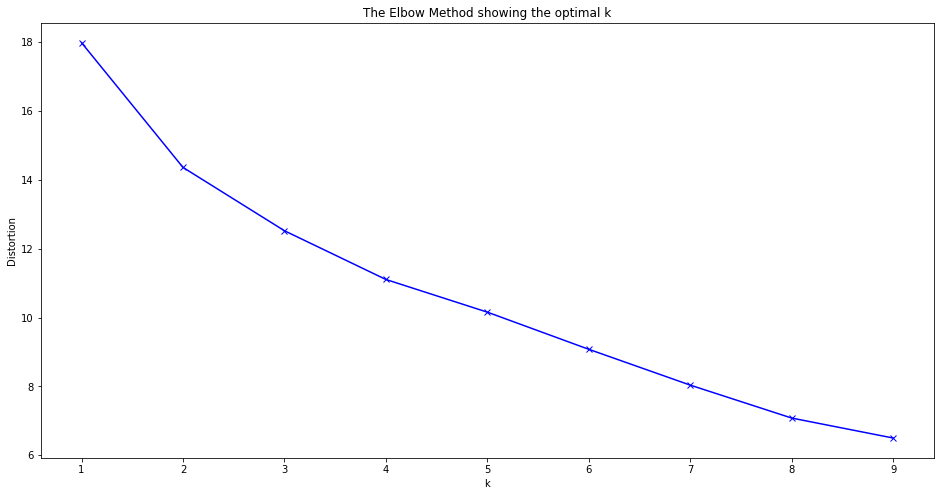

In [20]:
#Plot the Elbow method to choose the best number of clusters

import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans


to_grouped_clustering_elbow = to_grouped.drop('Neighborhood', 1)


distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0)
    kmeanModel.fit(to_grouped_clustering_elbow)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [21]:
# set number of clusters
kclusters = 6

to_grouped_clustering = to_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(to_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_.shape

(91,)

In [22]:
#Creating a new dataframe that includes the cluster as well as the top 20 venues for each neighborhood.


# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

to_merged = df_to.reset_index(drop=True)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

to_merged

,Postal code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,0,Food & Drink Shop,Food,European Restaurant,Doner Restaurant,Diner,Dessert Restaurant,Deli / Bodega,Comfort Food Restaurant,Coffee Shop,Central American Restaurant,Cafeteria,Burger Joint,Breakfast Restaurant,Bar and Pub,Bakery,BBQ Joint,Asian Restaurant,American Restaurant,Airport Food Court,Fast Food Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,2,Coffee Shop,European Restaurant,Wings Joint,Food,Doner Restaurant,Diner,Dessert Restaurant,Deli / Bodega,Comfort Food Restaurant,Central American Restaurant,Cafeteria,Burger Joint,Breakfast Restaurant,Bar and Pub,Bakery,BBQ Joint,Asian Restaurant,American Restaurant,Airport Food Court,Fast Food Restaurant
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636,1,Coffee Shop,European Restaurant,Asian Restaurant,Bakery,Restaurant,North American Restaurant,Breakfast Restaurant,Fast Food Restaurant,Health Food Store,Dessert Restaurant,Bar and Pub,Food Truck,Doner Restaurant,Diner,Deli / Bodega,Wings Joint,Comfort Food Restaurant,Central American Restaurant,Cafeteria,BBQ Joint
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763,4,Asian Restaurant,Dessert Restaurant,Restaurant,Fast Food Restaurant,Coffee Shop,European Restaurant,Seafood Restaurant,Fried Chicken Joint,Central American Restaurant,Doner Restaurant,Diner,Deli / Bodega,Comfort Food Restaurant,Wings Joint,Cafeteria,Breakfast Restaurant,Bar and Pub,Bakery,BBQ Joint,American Restaurant
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494,1,Coffee Shop,Asian Restaurant,European Restaurant,Bar and Pub,Burger Joint,North American Restaurant,Diner,Wings Joint,Juice Bar,Deli / Bodega,Vegetarian / Vegan Restaurant,Fried Chicken Joint,Food & Drink Shop,Middle East Restaurant,Restaurant,Latin American Restaurant,Comfort Food Restaurant,Airport Food Court,American Restaurant,Theme Restaurant
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242,2,Coffee Shop,Wings Joint,Food,European Restaurant,Doner Restaurant,Diner,Dessert Restaurant,Deli / Bodega,Comfort Food Restaurant,Central American Restaurant,Cafeteria,Burger Joint,Breakfast Restaurant,Bar and Pub,Bakery,BBQ Joint,Asian Restaurant,American Restaurant,Airport Food Court,Fast Food Restaurant
6,M1B,Scarborough,"Malvern , Rouge",43.806686,-79.194353,4,Fast Food Restaurant,Coffee Shop,African Restaurant,American Restaurant,Airport Food Court,European Restaurant,Doner Restaurant,Diner,Dessert Restaurant,Deli / Bodega,Comfort Food Restaurant,Central American Restaurant,Asian Restaurant,Food,Burger Joint,Breakfast Restaurant,Bar and Pub,Bakery,BBQ Joint,Cafeteria
7,M3B,North York,Don Mills,43.745906,-79.352188,3,Asian Restaurant,Central American Restaurant,Coffee Shop,Wings Joint,European Restaurant,Doner Restaurant,Diner,Dessert Restaurant,Deli / Bodega,Comfort Food Restaurant,Cafeteria,Food,Burger Joint,Breakfast Restaurant,Bar and Pub,Bakery,BBQ Joint,American Restaurant,Airport Food Court,Fast Food Restaurant
8,M4B,East York,"Parkview Hill , Woodbine Gardens",43.706397,-79.309937,4,Fast Food Restaurant,Restaurant,Cafeteria,European Restaurant,Doner Restaurant,Diner,Dessert Restaurant,Deli / Bodega,Comfort Food Restaurant,Coffee Shop,Central American Restaurant,Wings Joint,Food,Breakfast Restaurant,Bar and Pub,Bakery,BBQ Joint,Asian Restaurant,American Restaurant,Airport Food Court
9,M5B,Downtown Toronto,"Garden District, Ryerson",43

### 5. Vizualizing and defining the Clusters 

In [23]:
#Vizualizing the clusters in a folium map

address = 'Toronto, ON'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude


map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Latitude'], to_merged['Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [24]:
to_grouped['Cluster Labels'] = to_merged['Cluster Labels']
clusters = to_grouped.groupby("Cluster Labels").mean()
clusters

,African Restaurant,Airport Food Court,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bar and Pub,Breakfast Restaurant,Burger Joint,Cafeteria,Central American Restaurant,Coffee Shop,Comfort Food Restaurant,Deli / Bodega,Dessert Restaurant,Diner,Doner Restaurant,European Restaurant,Fast Food Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Fried Chicken Joint,Health Food Store,Hot Dog Joint,Jewish Restaurant,Juice Bar,Latin American Restaurant,Middle East Restaurant,Molecular Gastronomy Restaurant,North American Restaurant,Restaurant,Salon / Barbershop,Seafood Restaurant,Snack Place,Soup Place,South American Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Wings Joint
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,0.000000,0.000000,0.024898,0.189566,0.000000,0.000000,0.037398,0.020833,0.000000,0.0,0.033333,0.387873,0.000000,0.000000,0.034417,0.004065,0.000000,0.064465,0.059621,0.000000,0.000000,0.000000,0.000000,0.011111,0.000000,0.000000,0.000000,0.000000,0.020833,0.008130,0.000000,0.008130,0.055251,0.000000,0.036009,0.000000,0.000000,0.000000,0.000000,0.004065,0.000000
1.0,0.005319,0.005319,0.016646,0.192075,0.006427,0.059782,0.053048,0.030832,0.025991,0.0,0.011070,0.237344,0.001328,0.007178,0.011258,0.028372,0.000000,0.065209,0.055634,0.000575,0.002650,0.005457,0.001494,0.025280,0.000575,0.000000,0.000473,0.004571,0.003707,0.029095,0.000361,0.021363,0.052930,0.001573,0.008320,0.001478,0.000000,0.011865,0.000000,0.005486,0.009916
2.0,0.000000,0.000000,0.002597,0.102579,0.002646,0.160053,0.059750,0.022906,0.007792,0.0,0.002597,0.325831,0.002646,0.009211,0.012372,0.020212,0.000000,0.066831,0.003968,0.000000,0.008403,0.000000,0.002646,0.003968,0.000000,0.000000,0.000000,0.002597,0.000000,0.000000,0.002646,0.073122,0.071284,0.002597,0.011905,0.000000,0.000000,0.000000,0.002597,0.013646,0.002597
3.0,0.000000,0.000000,0.014880,0.162831,0.001916,0.046760,0.059803,0.022619,0.009353,0.0,0.022094,0.269756,0.003321,0.000000,0.018162,0.012089,0.000855,0.058273,0.055933,0.001355,0.057471,0.014744,0.001502,0.024074,0.006793,0.000000,0.000000,0.007034,0.002222,0.003271,0.000000,0.029688,0.072148,0.002315,0.003271,0.000000,0.000805,0.000000,0.000000,0.012349,0.002315
4.0,0.000000,0.000000,0.003367,0.326266,0.004329,0.036704,0.035173,0.001684,0.008264,0.0,0.000000,0.237366,0.001684,0.003367,0.003367,0.035985,0.001684,0.110745,0.038628,0.000000,0.000000,0.001684,0.001684,0.013047,0.000000,0.001684,0.000000,0.001684,0.015152,0.007365,0.000000,0.023656,0.040645,0.000000,0.016414,0.004329,0.000000,0.007365,0.000000,0.006734,0.009948


### 6. Using a fictitious dataframe to simulate the choices of each Chef member of the association

In [25]:
#read the chef dataset

df_chef = pd.read_excel(r'https://github.com/brunoflorencio/Coursera_Capstone/blob/master/Chefts.xlsx?raw=true')
print("chef shape:", df_chef.shape)
print("clusters shape:", clusters.shape)
df_chef

chef shape: (5, 41)
clusters shape: (5, 41)


,Name,Airport Food Court,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bar and Pub,Breakfast Restaurant','Burger Joint','Central American Restaurant',Coffee Shop','Comfort Food Restaurant','Deli / Bodega','Dessert Restaurant',Diner',Doner Restaurant','European Restaurant',Fast Food Restaurant',Food','Food & Drink Shop','Food Court','Food Truck',Fried Chicken Joint',Halal Restaurant','Health Food Store',Hot Dog Joint',Jewish Restaurant',Juice Bar','Latin American Restaurant','Middle East Restaurant','Molecular Gastronomy Restaurant','North American Restaurant','Restaurant',Salon / Barbershop',Seafood Restaurant','Snack Place','Soup Place','South American Restaurant','Theme Restaurant','Vegetarian / Vegan Restaurant','Wings Joint'
0,Chef Joey,0,10,2,0,0,0,0,0,10,10,1,0,10,2,0,0,10,0,1,1,0,0,0,10,3,0,0,0,10,10,10,6,0,0,9,0,8,8,4,0
1,Chef Rose,0,5,10,10,5,8,10,8,10,6,6,6,8,6,10,6,3,7,4,10,10,3,10,0,0,10,9,10,10,0,5,10,0,6,0,10,6,6,10,10
2,Chef Peter,10,10,0,10,10,10,10,10,10,5,5,9,2,5,5,0,10,10,4,5,5,6,4,0,0,5,5,10,5,0,6,5,0,7,8,5,10,7,3,3
3,Chef John,2,2,0,2,2,8,6,0,0,10,10,10,10,8,9,10,6,7,5,10,9,10,10,3,10,10,6,5,10,10,10,9,0,10,3,9,10,10,0,1
4,Chef Omar,1,3,10,5,10,5,10,9,10,0,4,10,9,7,10,10,3,7,10,10,10,10,0,8,3,10,2,9,10,4,9,10,0,10,4,10,10,10,0,0


### 7. Using Content-Based Recommender Systems to get the list of recommended neighborhoods for each Chef

In [26]:
cheflist = [*range(0, df_chef.shape[0], 1)] 


for i in cheflist:
    user_profile = 0
    recommendationTable_df = 0
    user_cluster = 0
    
    #determmining the chef profile
    user_profile = df_chef.loc[(i),:].transpose()
    user_profile = user_profile.drop(["Name"],axis = 0)
    
    #Getting the cluster number
    recommendationTable_df = ((clusters*user_profile).sum(axis=1))/(user_profile.sum())
    recommendationTable_df = recommendationTable_df.sort_values(ascending=False)
    
    #Getting the list of neighbourhoods and printing the result
    user_cluster = to_merged[to_merged["Cluster Labels"] == recommendationTable_df.index[0]]
    user_cluster = user_cluster[["Borough", "Neighborhood"]]
    print("\033[1m" + "List of recommended neighborhoods to "+df_chef.at[i,"Name"]+":"   + "\033[0m")
    print("Cluster number: " + str(recommendationTable_df.index[0]) )
    print(user_cluster)
    print("     --------------------------------          ")



List of recommended neighborhoods to Chef Joey:
Cluster number: 4.0
         Borough                                       Neighborhood
3     North York                  Lawrence Manor , Lawrence Heights
6    Scarborough                                    Malvern , Rouge
8      East York                   Parkview Hill , Woodbine Gardens
16   Scarborough                Guildwood , Morningside , West Hill
25    North York                                  Hillcrest Village
30   Scarborough                                Scarborough Village
32    North York                   Northwood Park , York University
51          York  Del Ray , Mount Dennis , Keelsdale and Silvert...
79     Etobicoke  South Steeles , Silverstone , Humbergate , Jam...
80   Scarborough                     Steeles West , L'Amoreaux West
87  East Toronto              Business reply mail Processing CentrE
     --------------------------------          
List of recommended neighborhoods to Chef Rose:
Cluster number: 4.0


# END